In [1]:
import pickle
import numpy as np
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu,floatX=float32"
import scipy.ndimage
import matplotlib.pyplot as plt
import pymc3 as pm
import math

In [2]:
tracks = pickle.load(open("mario_tracks.pkl"))

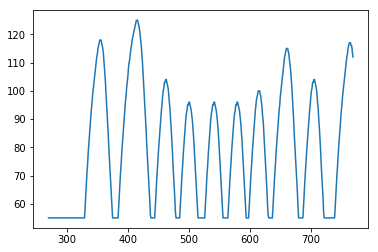

In [34]:

tracksToKeep=['track2']
kept = []
    

for track in sorted(tracks[1]):
    trackID = track[0]
    trackDict = track[1]
    trackDat = []
    for t in sorted(trackDict):
        trackDat.append([t] + list(trackDict[t][1]))
    trackDat = np.array(trackDat)
    if trackID in tracksToKeep:
        kept.append(trackDat)
    #plt.plot(trackDat[:,0],256-trackDat[:,2])
    #plt.show()
    
for track in sorted(tracks[0]):
    trackID = track
    track = tracks[0][trackID]
    trackDict = track
    trackDat = []
    for t in sorted(trackDict):
        trackDat.append([t] + list(trackDict[t][1]))
    trackDat = np.array(trackDat)
    if trackID in tracksToKeep:
        kept.append(trackDat)
    #plt.plot(trackDat[:,0],256-trackDat[:,2])
    #plt.show()
track = np.vstack(kept)
track = track[:500,:]
plt.plot(track[:,0],256-track[:,2])
plt.show()
    

In [35]:
def thresholds(vals, t_window=5):
    last_diff = 0
    last_diff_t = 0
    max_v = min(vals)
    min_v = max(vals)
    thresholds = set([0, min_v, max_v])
    for t, v in enumerate(vals):
        if (t - last_diff_t) == t_window:
            thresholds.add(last_diff)
        if v != last_diff:
            last_diff = v
            last_diff_t = t
    return thresholds

axis = 2
window = 3

velocities = track[1:,axis]-track[:-1,axis] 

thresholds(velocities)

{-4, -3, -2, -1, 0, 4, 5}

In [36]:
def samey_intervals(vals, t_window=5):
    last_diff = 0
    last_diff_t = 0
    intervals = []
    for t, v in enumerate(vals):
        if ((t - last_diff_t) >= t_window) and v != last_diff:
            intervals.append(last_diff_t)
            intervals.append(t-1)
            intervals.append(t)
        if v != last_diff:
            last_diff = v
            last_diff_t = t
    return intervals

axis = 2
window = 2

velocities = track[1:,axis]-track[:-1,axis] 
smoothed = scipy.ndimage.filters.convolve1d(velocities, np.ones(window)/window)

print velocities

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3 -3 -2 -3 -2 -2 -2
 -2 -2 -2 -2 -1 -2 -1 -1 -1  0  0  1  1  1  2  3  3  3  4  4  4  4  4  5  4
  4  4  4  4  4  0  0  0  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3 -3
 -3 -2 -3 -2 -2 -3 -2 -1 -2 -2 -1 -2 -1 -1 -1 -1 -1 -1 -1  0  0  1  1  1  2
  2  2  3  3  4  4  4  4  4  4  5  4  4  4  4  4  5  1  0  0  0  0  0  0 -4
 -4 -4 -4 -3 -4 -3 -3 -3 -3 -3 -2 -3 -2 -1 -2  0 -1  0  1  1  1  2  3  2  4
  3  4  4  5  4  4  4  5  2  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3
 -2 -1 -2  0 -1  0  1  1  1  2  2  3  3  4  4  4  4  4  4  4  0  0  0  0  0
  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3 -2 -1 -2  0 -1  0  1  1  1
  2  2  3  3  4  4  4  4  4  4  4  0  0  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4
 -3 -3 -3 -3 -2 -1 -2  0 -1  0  1  1  1  2  2  3  3  4  4  4  4  4  4  4  0
  0  0  0 -4

In [42]:
def zero_crossings(vals):
    sign_intervals = []
    last_sign_change = 0
    vsigns = np.sign(vals)
    last_sign = vsigns[0]
    for t, v in enumerate(vsigns):
        if last_sign == 0:
            last_sign = v
        elif v == 0 or v == last_sign:
            continue
        elif v != last_sign:
            sign_intervals.append(last_sign_change)
            sign_intervals.append(t-1)
            sign_intervals.append(t)
            sign_intervals.append(t+1)
            last_sign = v
            last_sign_change = t
    if t - 1 != last_sign_change:
        sign_intervals.append(last_sign_change)
        sign_intervals.append(t)
    return sign_intervals

axis = 2
window = 2

velocities = track[1:,axis]-track[:-1,axis] 
smoothed = scipy.ndimage.filters.convolve1d(velocities, np.ones(window)/window)


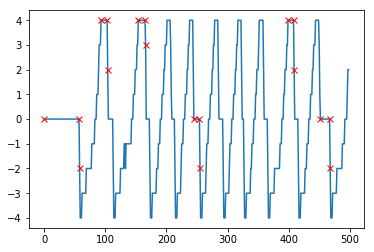

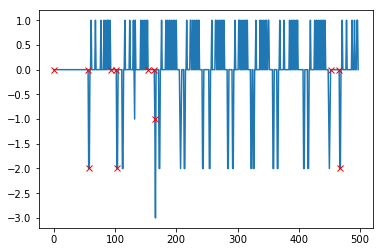

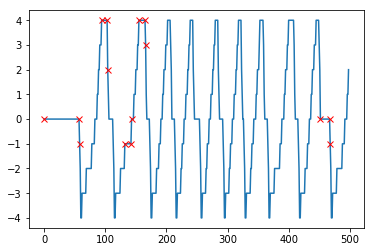

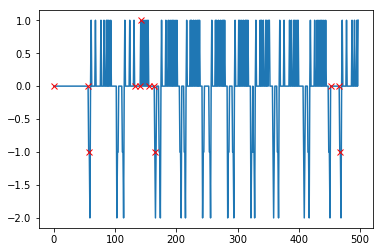

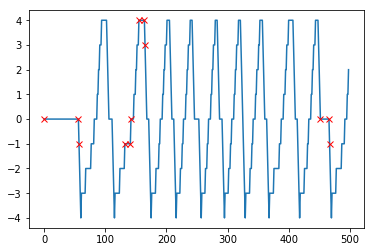

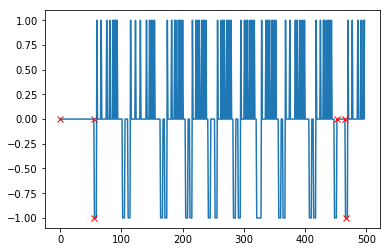

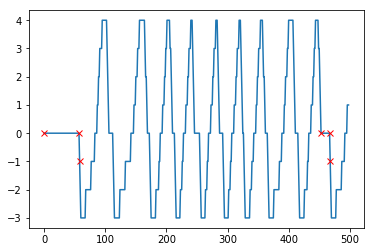

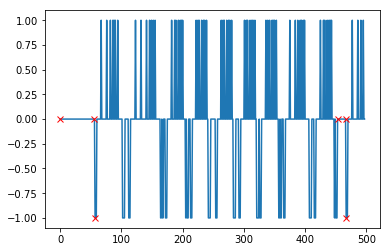

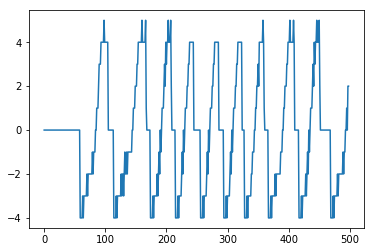

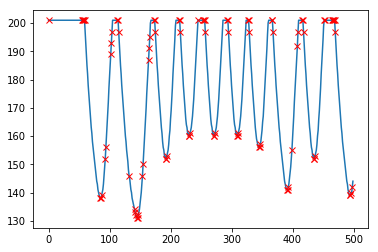

In [44]:
axis = 2

velocities = track[1:,axis]-track[:-1,axis] 

same_window = 10

switch_points = set(zero_crossings(velocities))

smoothed_points = set(samey_intervals(velocities,t_window=same_window))
for w in range(2,6):
    smoothed = scipy.ndimage.filters.convolve1d(velocities, np.ones(w)/w)
    #print smoothed
    plt.plot(smoothed)
    points = samey_intervals(smoothed,t_window=same_window)
    smoothed_points |= set(points)
    plt.plot(np.array(points),smoothed[np.array(points,dtype='int')],'rx')
    plt.show()
    smoothed = smoothed[1:]-smoothed[:-1]
    points = samey_intervals(smoothed,t_window=same_window)
    smoothed_points |= set(points)
    
    plt.plot(smoothed)
    plt.plot(np.array(points),smoothed[np.array(points,dtype='int')],'rx')
    plt.show()
    

velocity_times = sorted(switch_points |smoothed_points)

plt.plot(velocities)
plt.show()

plt.plot(track[:,2])
plt.plot(np.array(velocity_times),track[np.array(velocity_times,dtype='int'),2],'rx')
plt.show()


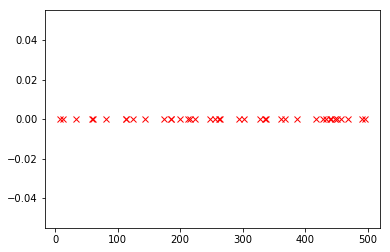

In [45]:
import fceulib
inputVec = fceulib.readInputs('Illustrative.fm2')

def button_change_times(button_masks):
    last_mask = 0
    mask_times = []
    for t, b in enumerate(button_masks):
        if t < track[0,0]:
            continue
        if t > track[-1,0]:
            break
        if b != last_mask:
            mask_times.append(t-track[0,0])
            last_mask = b
    return mask_times

button_times = button_change_times(inputVec)

plt.plot(np.array(button_times),np.array(button_times)*0,'rx')
plt.show()

In [9]:
# Templates is an array of model-generating functions of increasing complexity.
templates = [
    # Constant 0 velocity
    ("c0",lambda n,axis,vs,pv: pm.Normal(
        n, 
        mu=0,
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant velocity from old value
    ("cP",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pv,
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Fixed constant velocity
    ("cN",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pm.Normal(n+"_N",mu=0,sd=10),
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant acceleration from 0
    ("acc0",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pm.Normal(n+"_acc",mu=0,sd=10)*vs[:,0],
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant acceleration from old velocity value
    ("accP",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pv+pm.Normal(n+"_acc",mu=0,sd=10)*vs[:,0],
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant acceleration from fixed constant velocity
    ("accN",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pm.Normal(n+"_N",mu=0,sd=10)+pm.Normal(n+"_acc",mu=0,sd=20)*vs[:,0],
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
]
templates = templates
type2ind = {t[0]:i for i,t in enumerate(templates)}
print type2ind

{'accN': 5, 'cN': 2, 'acc0': 3, 'c0': 0, 'cP': 1, 'accP': 4}


In [10]:
iterations = 5000
def model_template_generate(template_i, axis, segment, prev_val):
    axisNames = [None,"x","y"]
    template = templates[template_i]
    (tn, t) = template
    with pm.Model() as model:
        lik = t(axisNames[axis],axis,segment,prev_val)
        step = pm.Metropolis()
        trace = pm.sample(iterations, step, progressbar=True)
        subtrace = trace[len(trace)/2:-1:10]
    return (tn,model,subtrace)

In [11]:
def model_set_generate(data):
    track,all_times,axis,i,j = data
    t0 = all_times[i]
    t1 = all_times[j]
    print "go",i,j,t0,t1
    if t0 == 0:
        segment = track[t0+1:t1+1]-track[t0:t1]
        prev_vel = float('inf')
    elif t1+1 > np.shape(track)[1]:
        extended_track = np.concatenate((track,[track[-1]]))
        segment = extended_track[t0+1:t1+1]-extended_track[t0:t1]
        prev_vel = track[t0,axis]-track[t0-1,axis]
    else:
        #9,10,11 - 8,9,10
        segment = track[t0+1:t1+1]-track[t0:t1]
        prev_vel = track[t0,axis]-track[t0-1,axis]
    segment[:,0] = range(0,np.shape(segment)[0])
    result = map(
        lambda ti: model_template_generate(ti, 
                                           axis,
                                           segment,
                                           prev_vel),
        range(0,len(templates)))
    return (i,j,t0,t1,result)

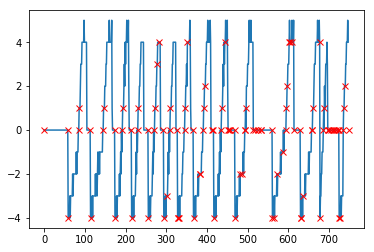

0
go 0 1 0 58


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '15745' (I am process '27824')
WARNING (theano.gof.cmodule): Deleting (broken cache directory [EOF]): /home/darkacloo/.theano/compiledir_Linux-4.2--generic-x86_64-with-Ubuntu-15.10-wily-x86_64-2.7.10-64/tmpCqi1WM
100%|██████████| 5000/5000 [00:00<00:00, 5051.88it/s]


-347.78843813
inf
-46.0205891928
-347.733396618
inf
-26.8353032293
go 0 2 0 59


100%|██████████| 5000/5000 [00:01<00:00, 4885.96it/s]


-347.892447438
inf
-49.9587144155
-347.839547133
inf
-27.4527022926
go 0 3 0 85


100%|██████████| 5000/5000 [00:01<00:00, 4802.16it/s]


1.83763830713
inf
1.73410960094
1.5336281052
inf
1.53806343966
58
go 1 3 58 85


100%|██████████| 5000/5000 [00:01<00:00, 4847.28it/s]


2.46502750766
2.46373737384
1.81967675548
2.37804652475
2.37670628534
1.67348693689
go 1 4 58 86


100%|██████████| 5000/5000 [00:01<00:00, 4826.17it/s]


2.44117118306
2.44222408804
1.86045974934
2.3787517409
2.37961182706
1.66485550724
go 1 5 58 113


100%|██████████| 5000/5000 [00:01<00:00, 4601.82it/s]


2.47478656717
2.47480539023
2.54247092793
2.46706679292
2.46952514631
2.2400660796
59
go 2 3 59 85


100%|██████████| 5000/5000 [00:01<00:00, 4756.18it/s]


2.48465273971
2.48331829794
1.76915287463
2.42638648818
2.42415788718
0.884405329621
go 2 4 59 86


100%|██████████| 5000/5000 [00:01<00:00, 4882.21it/s]


2.46259721437
2.46489679149
1.81717464097
2.4203852744
2.42740954831
0.895866614662
85
go 3 5 85 113


100%|██████████| 5000/5000 [00:01<00:00, 4730.46it/s]


2.56730598976
2.56571118893
2.25034061639
2.50651757324
2.50242825584
2.36731680221
go 3 6 85 114


100%|██████████| 5000/5000 [00:01<00:00, 3640.30it/s]


2.54042658551
2.54245600528
2.24780689717
2.50438081798
2.50412420462
2.34908236726
go 3 7 85 145


100%|██████████| 5000/5000 [00:01<00:00, 4721.91it/s]


2.44575108934
2.44629437358
2.50785001552
2.4355150797
2.43339180476
2.29638496091
86
go 4 5 86 113


100%|██████████| 5000/5000 [00:01<00:00, 4698.14it/s]


2.58449613538
2.58511209589
2.24663014283
2.55157519297
2.54685265543
2.33652608136
go 4 6 86 114


100%|██████████| 5000/5000 [00:01<00:00, 4559.02it/s]


2.56306295005
2.56328965526
2.25235467683
2.54696131846
2.53883666851
2.30396781291
113
go 5 7 113 145


100%|██████████| 5000/5000 [00:01<00:00, 4712.27it/s]


2.40325361909
2.40559756319
1.80115803984
2.32918258035
2.33106544538
1.55684871373
go 5 8 113 146


100%|██████████| 5000/5000 [00:01<00:00, 4751.71it/s]


2.38925130057
2.38989247195
1.83136054216
2.33057408281
2.32999027997
1.53626950869
go 5 9 113 173


100%|██████████| 5000/5000 [00:01<00:00, 4744.22it/s]


2.47321936245
2.47340966142
2.53624607904
2.44222315892
2.44550709635
2.07920957187
114
go 6 7 114 145


100%|██████████| 5000/5000 [00:01<00:00, 4770.83it/s]


2.4230546562
2.42484297067
1.76813457548
2.36861820496
2.36627936607
0.89360824423
go 6 8 114 146


100%|██████████| 5000/5000 [00:01<00:00, 4799.34it/s]


2.40546159621
2.4054412628
1.79848613904
2.36137698751
2.36691854035
0.878716810561
go 6 9 114 173


100%|██████████| 5000/5000 [00:01<00:00, 4821.01it/s]


2.48265174193
2.48179192897
2.54716484172
2.44993397194
2.45004687718
2.03772336661
145
go 7 9 145 173


100%|██████████| 5000/5000 [00:01<00:00, 4764.49it/s]


2.61492726508
2.61241114958
2.20438773921
2.44427493009
2.44286575978
2.36120173131
go 7 10 145 174


100%|██████████| 5000/5000 [00:01<00:00, 4967.66it/s]


2.5929033075
2.5942312878
2.21447220347
2.45799468769
2.45577366414
2.35690151036
146
go 8 9 146 173


100%|██████████| 5000/5000 [00:01<00:00, 4642.73it/s]


2.63334141358
2.63480349595
2.19282673347
2.4850241796
2.48617216145
2.34617153841
go 8 10 146 174


100%|██████████| 5000/5000 [00:01<00:00, 4745.85it/s]


2.61322083532
2.61041735335
2.2094744557
2.5004907975
2.50274152995
2.33206713854
173
go 9 11 173 192


100%|██████████| 5000/5000 [00:01<00:00, 4774.71it/s]


2.59247900382
2.59732276949
2.02044912449
2.53866471501
2.53528778903
2.09396646572
go 9 12 173 193


100%|██████████| 5000/5000 [00:01<00:00, 4957.69it/s]


2.5654215607
2.56427914624
2.06431772164
2.54444656155
2.54626641659
2.07467815305
174
go 10 11 174 192


100%|██████████| 5000/5000 [00:01<00:00, 4744.03it/s]


2.62527863858
2.62708310667
1.94296694321
2.62917079605
2.61352410145
1.43802429909
go 10 12 174 193


100%|██████████| 5000/5000 [00:01<00:00, 4640.73it/s]


2.59700016552
2.59751365487
2.01333014267
2.61118144088
2.61340197753
1.434834878
go 10 13 174 214


100%|██████████| 5000/5000 [00:01<00:00, 4557.46it/s]


2.53760032138
2.54090110379
2.63562702519
2.54835172381
2.54948912352
2.28112395605
192
go 11 13 192 214


100%|██████████| 5000/5000 [00:01<00:00, 4669.56it/s]


2.56863633637
2.81922947939
2.29030006837
2.49410626511
2.62767939404
2.48000132445
go 11 14 192 215


100%|██████████| 5000/5000 [00:01<00:00, 4882.23it/s]


2.54374872073
2.79441675325
2.29202806334
2.50515268895
2.64854048387
2.46298623218
193
go 12 13 193 214


100%|██████████| 5000/5000 [00:01<00:00, 4255.57it/s]


2.59718792765
2.59707998023
2.29055157451
2.55157973871
2.55794817813
2.47667479664
go 12 14 193 215


100%|██████████| 5000/5000 [00:01<00:00, 4513.75it/s]


2.57070333558
2.56947455726
2.29402634797
2.54942833094
2.54726889088
2.45011160818
214
go 13 15 214 230


100%|██████████| 5000/5000 [00:01<00:00, 4783.06it/s]


2.62521845415
2.6251856351
2.15078531054
2.62062526497
2.62341632857
2.29212201126
go 13 16 214 231


100%|██████████| 5000/5000 [00:01<00:00, 4694.51it/s]


2.59426982329
2.59280595722
2.18629131695
2.62553428194
2.62801508128
2.24937975011
215
go 14 15 215 230


100%|██████████| 5000/5000 [00:01<00:00, 4721.55it/s]


2.66671930406
2.66071553383
2.09310021195
2.73020442745
2.72400473247
1.62700804779
go 14 16 215 231


100%|██████████| 5000/5000 [00:01<00:00, 4544.95it/s]


2.62585650948
2.62690614064
2.15017112788
2.70429088158
2.70565740924
1.57643044526
go 14 17 215 255


100%|██████████| 5000/5000 [00:01<00:00, 4672.57it/s]


2.44275866784
2.44379684091
2.53646068264
2.48222210835
2.4835434546
2.39748835349
230
go 15 17 230 255


100%|██████████| 5000/5000 [00:01<00:00, 4742.00it/s]


2.37979403231
2.65585727358
2.21991119411
2.42639216396
2.58465681495
2.32438831583
go 15 18 230 256


100%|██████████| 5000/5000 [00:01<00:00, 4664.47it/s]


2.35659962865
2.63229310793
2.20617101926
2.40563237756
2.56719146805
2.28484161137
go 15 19 230 271


100%|██████████| 5000/5000 [00:01<00:00, 4786.31it/s]


2.42950409497
2.50005266608
2.52335844161
2.44951427414
2.5889059941
2.26484477795
231
go 16 17 231 255


100%|██████████| 5000/5000 [00:01<00:00, 4518.00it/s]


2.40517405185
2.40214519272
2.23246051263
2.47028462425
2.46376065297
2.28495667281
go 16 18 231 256


100%|██████████| 5000/5000 [00:01<00:00, 4646.79it/s]


2.38003430911
2.38080491415
2.22234220122
2.44787967518
2.44687040261
2.24210830798
go 16 19 231 271


100%|██████████| 5000/5000 [00:01<00:00, 4568.95it/s]


2.442655163
2.44276531798
2.53554017397
2.46295683142
2.46072435519
2.24463458531
255
go 17 19 255 271


100%|██████████| 5000/5000 [00:01<00:00, 4774.86it/s]


2.62624416334
2.62668608848
2.16147250844
2.62859826079
2.62536747104
2.3119142178
go 17 20 255 272


100%|██████████| 5000/5000 [00:01<00:00, 4844.25it/s]


2.5844046422
2.58946007889
2.17905406984
2.62542893148
2.62000904194
2.24880814253
256
go 18 19 256 271


100%|██████████| 5000/5000 [00:01<00:00, 4764.01it/s]


2.6665086472
2.66656130203
2.07744378252
2.72424800643
2.72019344249
1.63313020365
go 18 20 256 272


100%|██████████| 5000/5000 [00:01<00:00, 4453.73it/s]


2.62384164789
2.62574948669
2.14746736909
2.71042528094
2.71179298349
1.571337549
go 18 21 256 278


100%|██████████| 5000/5000 [00:01<00:00, 4618.42it/s]


2.50507931687
2.50427139026
2.50974937746
2.67627698695
2.6714814499
1.4628851942
go 18 22 256 282


100%|██████████| 5000/5000 [00:01<00:00, 4755.41it/s]


2.55724339438
2.55628288659
2.67676480031
2.65197145812
2.64852323849
1.37080198036
go 18 23 256 293


100%|██████████| 5000/5000 [00:01<00:00, 4696.52it/s]


2.4858631404
2.48651703809
2.58581516058
2.51836009399
2.51938699613
2.35931421365
271
go 19 21 271 278


100%|██████████| 5000/5000 [00:01<00:00, 4683.25it/s]


2.33532391133
2.70030605738
2.3652285
1.39277822433
2.10417391818
2.02466557544
go 19 22 271 282


100%|██████████| 5000/5000 [00:01<00:00, 4916.67it/s]


2.60637503715
2.87880480074
2.34122419112
0.99376913108
1.71410097292
1.35346199181
go 19 23 271 293


100%|██████████| 5000/5000 [00:01<00:00, 4478.57it/s]


2.45704609349
2.72127305779
2.25790921519
2.4587585486
2.60690373765
2.41582038907
272
go 20 21 272 278


100%|██████████| 5000/5000 [00:00<00:00, 5061.79it/s]


2.47070816688
2.45905137636
2.37140084289
1.99267267788
1.99496399808
2.47988192611
go 20 22 272 282


100%|██████████| 5000/5000 [00:01<00:00, 4455.03it/s]


2.67087379206
2.6646221999
2.311074977
1.44037323497
1.43389861538
1.50272845403
go 20 23 272 293


100%|██████████| 5000/5000 [00:01<00:00, 4787.41it/s]


2.48345147825
2.48680871727
2.26460285011
2.51335007725
2.5160912132
2.40482084415
278
go 21 23 278 293


100%|██████████| 5000/5000 [00:01<00:00, 4896.69it/s]


2.6155292181
2.35874026144
2.50971087674
2.81291235495
2.20193045797
2.27219858537
go 21 24 278 294


100%|██████████| 5000/5000 [00:01<00:00, 4973.72it/s]


2.57189944543
2.37064884813
2.49441456085
2.76944148994
2.14419761513
2.21626432832
go 21 25 278 303


100%|██████████| 5000/5000 [00:01<00:00, 4699.97it/s]


2.63156019275
2.96338438489
2.78161897847
2.6540427391
2.09077644151
2.10239984829
go 21 26 278 309


100%|██████████| 5000/5000 [00:01<00:00, 4742.87it/s]


2.54670925441
2.96040270253
2.66201833822
2.53468619091
2.23356958085
2.37197796127
282
go 22 23 282 293


100%|██████████| 5000/5000 [00:01<00:00, 4837.47it/s]


2.51768904174
2.77218515865
2.66213916637
2.84925199121
2.10670118963
2.51953209074
go 22 24 282 294


100%|██████████| 5000/5000 [00:01<00:00, 4870.17it/s]


2.4617379781
2.78549559097
2.59264808031
2.77778431102
2.09327261719
2.45648533907
go 22 25 282 303


100%|██████████| 5000/5000 [00:01<00:00, 4642.15it/s]


2.60221265134
3.21675693455
2.75255424673
2.49616630672
2.03921430918
2.22209784857
go 22 26 282 309


100%|██████████| 5000/5000 [00:01<00:00, 4614.74it/s]


2.50393274511
3.19681736504
2.58677787235
2.41272481064
2.43170363141
2.46296283185
293
go 23 25 293 303


100%|██████████| 5000/5000 [00:01<00:00, 4650.40it/s]


2.85766463159
2.86802523796
2.27158915571
2.70147796814
2.70144895549
2.70071843469
go 23 26 293 309


100%|██████████| 5000/5000 [00:01<00:00, 4587.91it/s]


2.62789357966
2.6275761487
2.15479714437
2.62972847191
2.62960334238
2.29326310151
go 23 27 293 310


100%|██████████| 5000/5000 [00:01<00:00, 4679.58it/s]


2.59233816925
2.58819856826
2.18797774084
2.63257383722
2.6243613335
2.25941952036
294
go 24 25 294 303


100%|██████████| 5000/5000 [00:01<00:00, 4550.05it/s]


2.91978669514
2.92566177013
1.59632662705
2.93575263109
2.94415056285
1.67422739827
go 24 26 294 309


100%|██████████| 5000/5000 [00:01<00:00, 4820.05it/s]


2.66391566681
2.66665627738
2.0930873312
2.72286890808
2.72602306715
1.63481882888
303
go 25 26 303 309


100%|██████████| 5000/5000 [00:00<00:00, 5037.63it/s]


2.45073912244
2.44284652994
2.56702802299
3.00181721212
2.26399297193
3.04450259615
go 25 27 303 310


100%|██████████| 5000/5000 [00:01<00:00, 4543.39it/s]


2.31971441225
2.47954317264
2.477543952
2.80962588601
2.0189472957
2.66493642434
go 25 28 303 327


100%|██████████| 5000/5000 [00:01<00:00, 4662.08it/s]


2.46653156219
3.07993374875
2.47738603161
2.26715386711
2.36798416435
2.40117754253
309
go 26 28 309 327


100%|██████████| 5000/5000 [00:01<00:00, 4373.75it/s]


2.57646772912
2.82756848416
2.26880427485
2.40578538071
2.55727043422
2.5137668499
go 26 29 309 328


100%|██████████| 5000/5000 [00:01<00:00, 4709.26it/s]


2.54175038084
2.80470931445
2.27299167369
2.44666261528
2.58811121663
2.51019925802
310
go 27 28 310 327


100%|██████████| 5000/5000 [00:01<00:00, 4755.66it/s]


2.60782712641
2.61217995496
2.25827458429
2.49401933285
2.48365652348
2.52776611646
go 27 29 310 328


100%|██████████| 5000/5000 [00:01<00:00, 4785.61it/s]


2.57459924186
2.58248429993
2.2713039038
2.50954053529
2.5161964679
2.52078797857
327
go 28 32 327 345


100%|██████████| 5000/5000 [00:01<00:00, 4712.12it/s]


2.59038477347
2.58501162655
2.08952501133
2.58221766477
2.57832238881
2.14039972326
go 28 33 327 346


100%|██████████| 5000/5000 [00:01<00:00, 4796.33it/s]


2.55546773113
2.55688917086
2.12306251199
2.57580253962
2.57632804172
2.09886903464
328
go 29 32 328 345


100%|██████████| 5000/5000 [00:01<00:00, 4914.37it/s]


2.62310212091
2.62362160504
2.03561961311
2.6550059419
2.66124623794
1.32963842048
go 29 33 328 346


100%|██████████| 5000/5000 [00:01<00:00, 4868.88it/s]


2.58769891794
2.59112249536
2.09170893052
2.65103091725
2.65022859134
1.29798701485
go 29 34 328 352


100%|██████████| 5000/5000 [00:01<00:00, 4917.31it/s]


2.48898633281
2.4901408156
2.48296945943
2.64887535841
2.64813170227
1.40098010961
329
go 30 32 329 345


100%|██████████| 5000/5000 [00:01<00:00, 4894.70it/s]


2.6062544252
2.21976821302
2.05086203374
2.6627092529
1.18568823868
1.3489823501
go 30 33 329 346


100%|██████████| 5000/5000 [00:01<00:00, 4944.68it/s]


2.57137295836
2.29530945759
2.10310178622
2.64590420576
1.16578091254
1.30180596498
go 30 34 329 352


100%|██████████| 5000/5000 [00:01<00:00, 4940.86it/s]


2.46698742773
2.76120252227
2.48429179746
2.63507900638
1.40039968735
1.3625651255
331
go 31 32 331 345


100%|██████████| 5000/5000 [00:01<00:00, 4909.06it/s]


2.55709508576
2.30421561581
2.07321323538
2.66452846093
1.15093258211
1.46507752133
go 31 33 331 346


100%|██████████| 5000/5000 [00:01<00:00, 4950.71it/s]


2.50638460957
2.38037188272
2.11885689417
2.63238455722
1.09977350972
1.38637607336
go 31 34 331 352


100%|██████████| 5000/5000 [00:01<00:00, 4966.78it/s]


2.40619465427
2.81275429917
2.48755549108
2.58862114718
1.23470222076
1.34942408253
345
go 32 34 345 352


100%|██████████| 5000/5000 [00:00<00:00, 5040.82it/s]


2.40369737377
2.39877659285
2.35379886171
1.82927960111
1.84633335792
2.42730875237
go 32 35 345 366


100%|██████████| 5000/5000 [00:01<00:00, 4959.01it/s]


2.54788563881
2.5441295714
2.30111629922
2.51761894468
2.50808851256
2.48276576618
346
go 33 34 346 352


100%|██████████| 5000/5000 [00:00<00:00, 5508.33it/s]


2.52482359002
2.51999971135
2.29790397726
2.35783768876
2.3635993435
2.71510398638
go 33 35 346 366


100%|██████████| 5000/5000 [00:01<00:00, 4983.48it/s]


2.57340607439
2.57810808501
2.28928022915
2.56941896611
2.57536561179
2.47411687063
go 33 36 346 367


100%|██████████| 5000/5000 [00:01<00:00, 4959.06it/s]


2.54644638189
2.5459397958
2.28696662776
2.56597789507
2.56564190022
2.42579546199
go 33 37 346 383


100%|██████████| 5000/5000 [00:00<00:00, 5045.52it/s]


2.55904389695
2.55758636102
2.65849906635
2.55626457466
2.56136968182
2.30999713995
352
go 34 35 352 366


100%|██████████| 5000/5000 [00:00<00:00, 5000.61it/s]


2.72139577649
2.31784128006
2.55828325331
2.92137980761
2.54725948061
2.30784818255
go 34 36 352 367


100%|██████████| 5000/5000 [00:01<00:00, 4971.77it/s]


2.67228771713
2.29729249572
2.5524307581
2.87541241916
2.50297501637
2.23126690871
go 34 37 352 383


100%|██████████| 5000/5000 [00:01<00:00, 4968.26it/s]


2.62061970176
2.85408432859
2.73027237915
2.56534335313
2.28658803863
2.3111100551
366
go 35 37 366 383


100%|██████████| 5000/5000 [00:00<00:00, 5036.59it/s]


2.66914614607
2.66858588515
1.85825773002
2.48610792327
2.48147073829
2.08511830924
go 35 38 366 384


100%|██████████| 5000/5000 [00:01<00:00, 4907.86it/s]


2.64693658024
2.64528905281
1.8210430646
2.47353842897
2.47401227273
2.02380438146
go 35 39 366 391


100%|██████████| 5000/5000 [00:01<00:00, 4862.27it/s]


2.49564571981
2.49408451665
1.84561280167
2.41312140249
2.40329177779
1.74950562121
go 35 40 366 392


100%|██████████| 5000/5000 [00:01<00:00, 4812.31it/s]


2.47186428292
2.47228593181
1.89138953697
2.40990608658
2.41527104638
1.73032391977
go 35 41 366 395


100%|██████████| 5000/5000 [00:01<00:00, 4658.48it/s]


2.424083108
2.42617766442
2.12490758289
2.47349436661
2.47339080873
1.79838392607
367
go 36 37 367 383


100%|██████████| 5000/5000 [00:01<00:00, 4859.13it/s]


2.7009719491
2.70792800805
1.58925105394
2.60322370258
2.608531917
1.0960391048
go 36 38 367 384


100%|██████████| 5000/5000 [00:01<00:00, 4840.41it/s]


2.6808985358
2.67635652054
1.58758126565
2.57034122765
2.56862684767
1.0375258038
go 36 39 367 391


100%|██████████| 5000/5000 [00:01<00:00, 4276.08it/s]


2.5169531723
2.51630707522
1.78381036406
2.46676516327
2.46589604783
0.932931154018
go 36 40 367 392


100%|██████████| 5000/5000 [00:01<00:00, 4867.91it/s]


2.49255530796
2.49499854298
1.85053496431
2.46154674679
2.46289310513
0.940963823387
383
go 37 39 383 391


100%|██████████| 5000/5000 [00:01<00:00, 4858.49it/s]


2.20529333112
1.77478875325
2.00005323387
2.56336134131
1.40216832423
1.84492407691
go 37 40 383 392


100%|██████████| 5000/5000 [00:01<00:00, 4874.77it/s]


2.11283265533
1.86717098347
1.98740678582
2.44622428301
1.26858071011
1.62092273666
go 37 41 383 395


100%|██████████| 5000/5000 [00:01<00:00, 4849.62it/s]


2.02315500178
2.29812120224
2.25916350884
2.33428136507
1.36297256186
1.49240429966
384
go 38 39 384 391


100%|██████████| 5000/5000 [00:01<00:00, 4912.13it/s]


2.21010285487
1.88942420674
2.12979001195
2.64853788874
1.4433061636
2.00989354844
go 38 40 384 392


100%|██████████| 5000/5000 [00:01<00:00, 4897.56it/s]


2.10746630097
1.94923908845
2.09349921701
2.52106739324
1.24301322258
1.73350440306
go 38 41 384 395


100%|██████████| 5000/5000 [00:01<00:00, 4831.14it/s]


2.01273377436
2.35901508947
2.30431529521
2.32677639724
1.23469177278
1.43920407381
go 38 42 384 413


100%|██████████| 5000/5000 [00:01<00:00, 4802.95it/s]


2.55403175679
2.96459450225
2.46165206874
2.22119702969
2.27122447131
2.35753696045
391
go 39 42 391 413


100%|██████████| 5000/5000 [00:01<00:00, 4683.85it/s]


2.68585743763
2.68567992953
2.23681546929
2.41775342977
2.41933344687
2.42962236414
go 39 43 391 416


100%|██████████| 5000/5000 [00:01<00:00, 4794.28it/s]


2.61223185937
2.60917068659
2.27813999567
2.5129279319
2.51274192325
2.43739547537
392
go 40 42 392 413


100%|██████████| 5000/5000 [00:01<00:00, 4786.36it/s]


2.70763224388
2.71077335848
2.20835580784
2.48880724886
2.48695347526
2.42024666569
go 40 43 392 416


100%|██████████| 5000/5000 [00:01<00:00, 4786.86it/s]


2.63648559771
2.63362667626
2.263190536
2.55864582127
2.55645013712
2.41140289556
395
go 41 42 395 413


100%|██████████| 5000/5000 [00:01<00:00, 4782.36it/s]


2.78904296294
2.22941197514
2.2551268392
2.68990625488
2.3761902629
2.47089345881
go 41 43 395 416


100%|██████████| 5000/5000 [00:01<00:00, 4771.69it/s]


2.69759018864
2.20889969383
2.33439356899
2.7037867612
2.38820165832
2.38040090817
go 41 44 395 417


100%|██████████| 5000/5000 [00:01<00:00, 4744.66it/s]


2.67028406876
2.20605667988
2.34359659845
2.69449875317
2.37494703626
2.35091315871
go 41 45 395 435


100%|██████████| 5000/5000 [00:01<00:00, 4846.64it/s]


2.59519634941
2.74368562335
2.6876049923
2.62610517866
2.37457058249
2.34465496818
413
go 42 45 413 435


100%|██████████| 5000/5000 [00:01<00:00, 4713.14it/s]


2.50712023721
2.505321005
2.10861325523
2.33399986224
2.33142610815
2.30637499924
go 42 46 413 436


100%|██████████| 5000/5000 [00:01<00:00, 4644.54it/s]


2.48288503025
2.48720676739
2.11846736305
2.36574531866
2.35950595829
2.31410523003
416
go 43 45 416 435


100%|██████████| 5000/5000 [00:01<00:00, 4905.29it/s]


2.5922744518
2.59467338082
2.0149680727
2.54237010512
2.54170331159
2.08631731748
go 43 46 416 436


100%|██████████| 5000/5000 [00:01<00:00, 4933.96it/s]


2.5617380955
2.56204999407
2.05854550868
2.54320752046
2.55110523684
2.06200842184
417
go 44 45 417 435


100%|██████████| 5000/5000 [00:01<00:00, 4994.70it/s]


2.62280062896
2.62611396784
1.93366372594
2.62089876627
2.6233409086
1.43977305705
go 44 46 417 436


100%|██████████| 5000/5000 [00:01<00:00, 4997.45it/s]


2.59395587026
2.59543230755
2.02409218095
2.61742833637
2.61008983501
1.43261314105
go 44 47 417 444


100%|██████████| 5000/5000 [00:01<00:00, 4839.24it/s]


2.5073875384
2.51321660774
2.55515250233
2.64764729876
2.64439108178
1.56907403556
435
go 45 47 435 444


100%|██████████| 5000/5000 [00:01<00:00, 4848.63it/s]


2.50283624186
2.797389668
2.35780395821
1.65867291128
2.05288304964
2.15699792725
go 45 48 435 452


100%|██████████| 5000/5000 [00:01<00:00, 4836.11it/s]


2.72248396167
2.96213416975
2.21079751496
1.91595140569
2.16010798135
2.06769638738
436
go 46 47 436 444


100%|██████████| 5000/5000 [00:01<00:00, 4715.58it/s]


2.58852340806
2.58514470335
2.36817172007
1.96099548967
1.97518619791
2.39173926499
go 46 48 436 452


100%|██████████| 5000/5000 [00:01<00:00, 4726.42it/s]


2.75742530169
2.76011559586
2.13612910245
2.05644775806
2.05417841483
2.08959938124
444
go 47 48 444 452


100%|██████████| 5000/5000 [00:01<00:00, 4718.97it/s]


3.07772556923
2.0803774636
2.20668947432
3.13388895432
2.41665240151
2.68252837949
go 47 49 444 455


100%|██████████| 5000/5000 [00:01<00:00, 4609.88it/s]


2.86090011689
2.32179645737
2.66421623201
3.08052818474
2.54877937564
2.61152091838
452
go 48 51 452 468


100%|██████████| 5000/5000 [00:01<00:00, 4884.14it/s]


-331.539382708
2.27637970914
-39.5672177915
-37.4319963036
1.89946458185
-26.9549331702
go 48 52 452 469


100%|██████████| 5000/5000 [00:01<00:00, 4889.11it/s]


-332.877653782
2.27215105642
-43.8658991236
-332.674283669
1.87203848748
-33.2431128844
go 48 53 452 482


100%|██████████| 5000/5000 [00:01<00:00, 4735.48it/s]


2.29734566821
2.82747384336
2.15815181646
1.77292295139
1.85201569448
1.85878438069
455
go 49 51 455 468


100%|██████████| 5000/5000 [00:01<00:00, 4954.20it/s]


-326.377995918
-326.381133301
-45.1635610671
-41.2676237138
-326.143214308
-29.6509371446
go 49 52 455 469


100%|██████████| 5000/5000 [00:00<00:00, 5083.19it/s]


-328.360253757
-328.352086983
-328.130389771
-44.1077173301
-328.125921909
-27.2423634542
go 49 53 455 482


100%|██████████| 5000/5000 [00:01<00:00, 4754.09it/s]


2.35711920615
2.35782797325
2.20370656119
1.79676313077
1.78870851251
1.92184192058
456
go 50 51 456 468


100%|██████████| 5000/5000 [00:00<00:00, 5053.89it/s]


-324.094692869
-324.089642597
-45.1718695617
-40.67836465
-39.655160003
-26.0331770331
go 50 52 456 469


100%|██████████| 5000/5000 [00:01<00:00, 4999.57it/s]


-326.384183977
-326.394402026
-39.0938743579
-326.135567776
-43.4127275348
-28.723745334
go 50 53 456 482


100%|██████████| 5000/5000 [00:01<00:00, 4697.35it/s]


2.37815742393
2.37822105053
2.20324139192
1.80323628558
1.80835873237
1.94485140997
468
go 51 53 468 482


100%|██████████| 5000/5000 [00:01<00:00, 4650.98it/s]


2.74868588531
2.75040196889
1.94665078189
2.55311070794
2.53782956312
2.29048268543
go 51 54 468 485


100%|██████████| 5000/5000 [00:01<00:00, 4875.89it/s]


2.66255146209
2.66575828455
1.85060874976
2.4985847312
2.48881350136
2.07277432815
go 51 55 468 493


100%|██████████| 5000/5000 [00:01<00:00, 4765.69it/s]


2.50618775941
2.50422801836
1.76056339613
2.37247160936
2.37506031794
1.71875903514
go 51 56 468 494


100%|██████████| 5000/5000 [00:01<00:00, 4776.28it/s]


2.48435656743
2.48059413635
1.82726093244
2.38635161088
2.38653969945
1.72172317775
469
go 52 53 469 482


100%|██████████| 5000/5000 [00:01<00:00, 4787.58it/s]


2.79719897111
2.79871471786
1.51176003237
2.6988770514
2.69144904845
1.34807989148
go 52 54 469 485


100%|██████████| 5000/5000 [00:01<00:00, 4860.87it/s]


2.70003804651
2.70448497879
1.58765341538
2.59439124107
2.59940241079
1.11370851931
go 52 55 469 493


100%|██████████| 5000/5000 [00:01<00:00, 4779.62it/s]


2.52861169741
2.5272360001
1.66673994706
2.43893073846
2.43522310549
0.868483629066
go 52 56 469 494


100%|██████████| 5000/5000 [00:01<00:00, 4772.38it/s]


2.50369211998
2.50421056542
1.76329564796
2.44003261826
2.44502515575
0.949009763706
482
go 53 55 482 493


100%|██████████| 5000/5000 [00:01<00:00, 4751.46it/s]


2.24719302692
1.98670768576
1.3244250215
2.24856677332
1.46412254571
1.43705907157
go 53 56 482 494


100%|██████████| 5000/5000 [00:01<00:00, 4736.16it/s]


2.18770291892
2.09644287795
1.60025762674
2.2797038276
1.4165802148
1.56871397758
485
go 54 55 485 493


100%|██████████| 5000/5000 [00:01<00:00, 4739.82it/s]


2.2844099126
1.39135656803
1.67289537305
2.47868465867
1.37279998093
1.93466797589
go 54 56 485 494


100%|██████████| 5000/5000 [00:01<00:00, 4771.75it/s]


2.20177179044
1.66169633281
1.86479870147
2.45219600571
1.45883998972
1.91800819548
493
go 55 58 493 514


100%|██████████| 5000/5000 [00:01<00:00, 4645.29it/s]


2.72836202071
2.95740834514
2.18170976245
1.63910613921
1.93632266694
1.75169458318
go 55 59 493 518


100%|██████████| 5000/5000 [00:01<00:00, 4708.74it/s]


2.62288609531
2.86594658674
2.26139243615
2.39686931142
2.53298853815
2.42987408862
494
go 56 58 494 514


100%|██████████| 5000/5000 [00:01<00:00, 4701.94it/s]


2.75751885917
2.75438147978
2.12123332714
1.75763217415
1.75692600791
1.78616376727
go 56 59 494 518


100%|██████████| 5000/5000 [00:01<00:00, 4681.02it/s]


2.64701045475
2.65017344136
2.25016622535
2.44228973171
2.44818515462
2.43267546206
495
go 57 58 495 514


100%|██████████| 5000/5000 [00:01<00:00, 4700.35it/s]


2.78364710555
2.78546878032
2.03214537456
1.89264410877
1.89073672482
1.77958611627
go 57 59 495 518


100%|██████████| 5000/5000 [00:01<00:00, 4663.07it/s]


2.67098261076
2.67223757526
2.23681892511
2.49915438655
2.50269666376
2.42545268844
514
go 58 60 514 526


100%|██████████| 5000/5000 [00:01<00:00, 4582.45it/s]


-324.085161329
2.96974257154
-41.20898809
-323.817609628
2.69275587506
-24.9427698983
go 58 61 514 532


100%|██████████| 5000/5000 [00:01<00:00, 4845.36it/s]


-334.050644897
2.92022024281
-44.6047756927
-333.873193772
2.5029729781
-28.1135448438
go 58 62 514 534


100%|██████████| 5000/5000 [00:01<00:00, 4945.04it/s]


-336.041694483
2.90526925795
-44.5849025781
-47.7040809634
2.46251909941
-32.9610732824
go 58 63 514 560


100%|██████████| 5000/5000 [00:01<00:00, 4880.79it/s]


-346.17757739
2.84916118727
-47.171716366
-43.2569580301
2.2646468127
-24.0550074518
go 58 64 514 561


100%|██████████| 5000/5000 [00:01<00:00, 4923.16it/s]


-346.342503258
2.84760468446
-44.8597780287
-43.2311291012
2.26244862248
-30.5996828536
go 58 65 514 564


100%|██████████| 5000/5000 [00:01<00:00, 4687.90it/s]


1.46479017461
2.92854131704
1.50915002633
1.44754517095
2.24606482865
1.5076149941
518
go 59 60 518 526


100%|██████████| 5000/5000 [00:01<00:00, 4961.63it/s]


-309.133159547
-309.148134118
-36.4759259301
-36.3557864823
-308.73640336
-26.2551111509
go 59 61 518 532


100%|██████████| 5000/5000 [00:00<00:00, 5089.34it/s]


-328.36242012
-328.365263184
-42.8059396169
-328.1277601
-328.127089216
-20.4237196603
go 59 62 518 534


100%|██████████| 5000/5000 [00:01<00:00, 4964.55it/s]


-331.55874195
-331.561852631
-40.9137750043
-43.5137910083
-41.1277345131
-21.8843778171
go 59 63 518 560


100%|██████████| 5000/5000 [00:01<00:00, 4648.44it/s]


-345.43358026
-345.432503246
-47.5348208093
-38.9946868865
-345.35566899
-32.6120229382
go 59 64 518 561


100%|██████████| 5000/5000 [00:01<00:00, 4613.78it/s]


-345.631305786
-345.631882331
-46.5527735047
-345.560291364
-345.554040543
-26.9456787761
go 59 65 518 564


100%|██████████| 5000/5000 [00:01<00:00, 4572.79it/s]


1.50986388445
1.51235916544
1.55600574451
1.48974560046
1.49315545539
1.55606703656
526
go 60 61 526 532


100%|██████████| 5000/5000 [00:00<00:00, 5010.67it/s]


-294.204134257
-294.19836598
-33.8390756084
-31.3851717212
-36.1812561896
-22.4659510848
go 60 62 526 534


100%|██████████| 5000/5000 [00:01<00:00, 4809.35it/s]


-309.126131581
-309.137156343
-40.3001073467
-38.8049567892
-38.5995563995
-25.848717746
go 60 63 526 560


100%|██████████| 5000/5000 [00:01<00:00, 4916.82it/s]


-343.421922012
-343.426660595
-46.5962580303
-45.3862070506
-343.332270934
-27.6475583528
go 60 64 526 561


100%|██████████| 5000/5000 [00:01<00:00, 4824.61it/s]


-343.723326394
-343.727450365
-46.2526561658
-343.630651873
-343.635132739
-25.2929387784
go 60 65 526 564


100%|██████████| 5000/5000 [00:01<00:00, 4564.93it/s]


1.62178309751
1.6178485882
1.67676017114
1.59480108644
1.59287912565
1.67695303892
532
go 61 63 532 560


100%|██████████| 5000/5000 [00:01<00:00, 4791.25it/s]


-341.164009167
-341.162719014
-45.0812810457
-42.2520922831
-341.045550865
-25.0269954682
go 61 64 532 561


100%|██████████| 5000/5000 [00:01<00:00, 4802.62it/s]


-341.605284619
-341.606439186
-45.8132233501
-341.4976994
-39.2901312349
-26.7037210871
go 61 65 532 564


100%|██████████| 5000/5000 [00:01<00:00, 4787.18it/s]


1.71426908701
1.71792917858
1.78436224831
1.68864057863
1.68948386331
1.78570164161
534
go 62 63 534 560


100%|██████████| 5000/5000 [00:01<00:00, 4782.75it/s]


-340.179420749
-340.179971923
-38.98992905
-41.3156169967
-340.053833309
-26.9955602723
go 62 64 534 561


100%|██████████| 5000/5000 [00:01<00:00, 4860.08it/s]


-340.688525186
-340.69060051
-50.7762678449
-37.6057241423
-340.570932898
-23.5572774671
go 62 65 534 564


100%|██████████| 5000/5000 [00:01<00:00, 4729.42it/s]


1.75352273801
1.75453539304
1.83197776156
1.72760470375
1.72549197586
1.82188812296
560
go 63 66 560 572


100%|██████████| 5000/5000 [00:01<00:00, 4581.17it/s]


2.81545834461
2.81228510331
2.06108047155
2.60550629023
2.59800236847
2.43673631545
go 63 67 560 586


100%|██████████| 5000/5000 [00:01<00:00, 4521.53it/s]


2.48475759562
2.48581704808
1.76622845619
2.36641240121
2.36097767213
1.68125396742
go 63 68 560 594


100%|██████████| 5000/5000 [00:01<00:00, 4761.02it/s]


2.34182878659
2.34285180346
1.88720572592
2.32722157009
2.32918054628
1.48635345819
go 63 69 560 595


100%|██████████| 5000/5000 [00:01<00:00, 4462.81it/s]


2.32423042404
2.32382261225
1.89229894755
2.31722376613
2.3158387608
1.45903900836
go 63 70 560 598


100%|██████████| 5000/5000 [00:01<00:00, 4564.20it/s]


2.29844366632
2.29355256148
2.03339402249
2.34178316705
2.33984478289
1.47135796703
561
go 64 66 561 572


100%|██████████| 5000/5000 [00:01<00:00, 4560.35it/s]


2.86160625296
2.8672128534
1.44527636606
2.78710976724
2.77396909668
1.38326296915
go 64 67 561 586


100%|██████████| 5000/5000 [00:01<00:00, 4513.65it/s]


2.50651189644
2.50517763688
1.68741475693
2.42073240931
2.42007442533
0.844923129148
go 64 68 561 594


100%|██████████| 5000/5000 [00:01<00:00, 4556.19it/s]


2.35769603623
2.35727595184
1.87148655748
2.35665633914
2.35517335155
0.70697683884
go 64 69 561 595


100%|██████████| 5000/5000 [00:01<00:00, 4640.56it/s]


2.3413828069
2.34100178032
1.88161023198
2.35100662576
2.34744590035
0.684944863237
go 64 70 561 598


100%|██████████| 5000/5000 [00:01<00:00, 4493.71it/s]


2.30779252182
2.30998404779
2.03069912904
2.36420107847
2.36379182104
0.832197513485
564
go 65 66 564 572


100%|██████████| 5000/5000 [00:01<00:00, 4467.71it/s]


2.87787068096
1.69797611123
1.56649174663
2.94712188308
1.4662698433
1.94841219176
go 65 67 564 586


100%|██████████| 5000/5000 [00:01<00:00, 4631.05it/s]


2.4376228598
2.1803247334
1.60993556813
2.35905453752
0.860435565712
0.952472788491
go 65 68 564 594


100%|██████████| 5000/5000 [00:01<00:00, 4657.91it/s]


2.26623012756
2.40881112439
1.80149821372
2.27875346456
0.738225594626
0.782118729673
go 65 69 564 595


100%|██████████| 5000/5000 [00:01<00:00, 4646.69it/s]


2.24822576291
2.43226199716
1.81345284787
2.26961011554
0.729141177966
0.756852884016
go 65 70 564 598


100%|██████████| 5000/5000 [00:01<00:00, 4433.23it/s]


2.21694990344
2.55342588416
1.97924006303
2.28741312863
0.797567533888
0.90136813216
572
go 66 67 572 586


100%|██████████| 5000/5000 [00:01<00:00, 4559.62it/s]


2.23101487673
1.91651860183
1.37758380675
2.20827202904
1.15822153953
1.27192265196
go 66 68 572 594


100%|██████████| 5000/5000 [00:01<00:00, 4495.95it/s]


1.97694520509
2.19791879128
1.58992346121
2.03920884326
0.891038811377
0.942749872705
go 66 69 572 595


100%|██████████| 5000/5000 [00:01<00:00, 4488.89it/s]


1.95102264961
2.21895285399
1.60546008869
2.01882613351
0.872261607826
0.902572930941
go 66 70 572 598


100%|██████████| 5000/5000 [00:01<00:00, 4481.25it/s]


1.93248975105
2.38523998409
1.84566960834
2.06047450454
0.926062966017
1.04811251073
586
go 67 68 586 594


100%|██████████| 5000/5000 [00:01<00:00, 4604.46it/s]


1.39122596782
1.62363261471
1.67560344941
1.86498558708
1.3532720476
1.93865507349
go 67 69 586 595


100%|██████████| 5000/5000 [00:01<00:00, 4646.19it/s]


1.29370531945
1.60216304475
1.54224710924
1.70337246009
1.20794140697
1.72478687
go 67 70 586 598


100%|██████████| 5000/5000 [00:01<00:00, 4690.06it/s]


1.55631700946
1.98992583898
1.87383941946
1.71439587762
1.18630629214
1.56219194319
go 67 71 586 602


100%|██████████| 5000/5000 [00:01<00:00, 4600.73it/s]


2.04996534348
2.37384007121
2.17533151761
1.71620698222
1.21054770779
1.40715258422
594
go 68 71 594 602


100%|██████████| 5000/5000 [00:01<00:00, 4536.79it/s]


2.49523782854
2.50470758382
2.35470406037
1.38410372472
1.40561519188
1.82302178833
go 68 72 594 605


100%|██████████| 5000/5000 [00:01<00:00, 4616.42it/s]


2.69822355856
2.69114506501
2.4036620974
1.32941015685
1.33980384041
1.64344379566
go 68 73 594 608


100%|██████████| 5000/5000 [00:01<00:00, 4583.98it/s]


2.7353742736
2.73463203906
2.23515858152
1.64300649386
1.61796023171
1.76576389761
595
go 69 71 595 602


100%|██████████| 5000/5000 [00:01<00:00, 4493.64it/s]


2.59785629478
2.59787044334
2.28674500986
2.01159599075
1.98873775231
2.01002876983
go 69 72 595 605


100%|██████████| 5000/5000 [00:01<00:00, 4661.39it/s]


2.76455890028
2.76068538705
2.33549373289
1.72957443183
1.73901515995
1.78129650177
go 69 73 595 608


100%|██████████| 5000/5000 [00:01<00:00, 4619.81it/s]


2.77938428618
2.78029909433
2.1373560856
1.88891953202
1.8803235494
1.76304440655
598
go 70 72 598 605


100%|██████████| 5000/5000 [00:01<00:00, 4658.97it/s]


2.9851311605
2.33608153429
2.35137861809
2.69424360679
1.78867865209
2.46749719323
go 70 73 598 608


100%|██████████| 5000/5000 [00:01<00:00, 4635.01it/s]


2.93491925557
2.27070075192
1.92819783725
2.51977764367
1.73951302029
2.03017194908
go 70 74 598 614


100%|██████████| 5000/5000 [00:01<00:00, 4579.83it/s]


2.92594515998
2.29321191281
1.6286224615
2.33977137399
1.60404030055
1.60731968053
go 70 75 598 629


100%|██████████| 5000/5000 [00:01<00:00, 4658.00it/s]


2.53488442911
2.20497633983
2.32593270315
2.60521581329
2.24623958129
2.05655529186
602
go 71 73 602 608


100%|██████████| 5000/5000 [00:00<00:00, 5107.54it/s]


3.18907693477
2.13895873855
1.82277549188
3.37901883704
2.4723999404
2.562164796
go 71 74 602 614


100%|██████████| 5000/5000 [00:01<00:00, 4558.87it/s]


3.04195876639
1.94759640976
1.2521811598
2.75903756974
1.74639667221
1.62565038083
go 71 75 602 629


100%|██████████| 5000/5000 [00:01<00:00, 4651.52it/s]


2.55072689355
2.38684854941
2.40659292821
2.65877684315
2.07063782791
1.96150329862
605
go 72 74 605 614


100%|██████████| 5000/5000 [00:01<00:00, 4428.99it/s]


3.08406520893
1.10525683804
1.44100428432
2.90077462893
1.35320334641
1.85709682478
go 72 75 605 629


100%|██████████| 5000/5000 [00:01<00:00, 4500.79it/s]


2.47202211721
2.6658011292
2.40418553535
2.61076200519
1.88091521956
2.06167171615
608
go 73 74 608 614


100%|██████████| 5000/5000 [00:01<00:00, 4970.89it/s]


3.21245665007
1.48666857068
1.98334043832
3.34125348546
1.96775389686
2.75386052032
go 73 75 608 629


100%|██████████| 5000/5000 [00:01<00:00, 4580.50it/s]


2.37902121623
2.74082359675
2.39768258001
2.5543962774
1.97914919926
2.1813674747
614
go 74 75 614 629


100%|██████████| 5000/5000 [00:01<00:00, 4637.01it/s]


-330.069667042
3.14970226786
-37.7019779212
-44.9243621612
2.78973131857
-29.7605959419
go 74 76 614 630


100%|██████████| 5000/5000 [00:01<00:00, 4722.51it/s]


-331.556077966
3.14696503219
-45.1888707753
-39.0778935332
2.767238194
-25.5004153394
go 74 77 614 632


100%|██████████| 5000/5000 [00:01<00:00, 4599.60it/s]


1.86842245043
3.23609621212
2.02291693221
1.90904034529
2.67607782378
2.11735109838
629
go 75 78 629 637


100%|██████████| 5000/5000 [00:01<00:00, 4581.19it/s]


2.93417278599
2.93589422107
2.54401975964
2.83589036945
2.81145120988
3.06444026072
go 75 79 629 657


100%|██████████| 5000/5000 [00:01<00:00, 4628.60it/s]


2.44434066366
2.44931795132
1.76515669516
2.34404575128
2.34099403428
1.62080257638
go 75 80 629 659


100%|██████████| 5000/5000 [00:01<00:00, 4615.03it/s]


2.40934879204
2.40832587433
1.83535446521
2.34869715137
2.35338857741
1.58669535974
go 75 81 629 660


100%|██████████| 5000/5000 [00:01<00:00, 4656.95it/s]


2.39240943392
2.39110142384
1.86362010372
2.34820190862
2.34789267142
1.56124760417
go 75 82 629 677


100%|██████████| 5000/5000 [00:01<00:00, 4556.46it/s]


2.52206185361
2.52263540416
2.59982408559
2.50543522707
2.50794236188
1.67833534656
630
go 76 78 630 637


100%|██████████| 5000/5000 [00:01<00:00, 4594.86it/s]


3.0269259511
3.03087352038
1.77152263213
3.16420176632
3.16947534242
2.22204336269
go 76 79 630 657


100%|██████████| 5000/5000 [00:01<00:00, 4482.58it/s]


2.46794535939
2.46890116371
1.71014768856
2.39523653216
2.39586053789
0.770992070344
go 76 80 630 659


100%|██████████| 5000/5000 [00:01<00:00, 4570.53it/s]


2.4276392775
2.42550922656
1.80711537723
2.39716148777
2.39275814373
0.788977652063
632
go 77 78 632 637


100%|██████████| 5000/5000 [00:00<00:00, 5006.85it/s]


3.13989582721
1.69774817659
2.30160241542
3.56120803226
2.15902480501
3.10530760915
go 77 79 632 657


100%|██████████| 5000/5000 [00:01<00:00, 4501.60it/s]


2.42179799129
2.19984374021
1.65579745773
2.35417527602
0.712064542502
0.846987977077
go 77 80 632 659


100%|██████████| 5000/5000 [00:01<00:00, 4588.30it/s]


2.37810648515
2.29626387045
1.77375079763
2.35240066698
0.698066962512
0.85007155412
go 77 81 632 660


100%|██████████| 5000/5000 [00:01<00:00, 4627.77it/s]


2.3575250806
2.32822545776
1.80806383025
2.34660520293
0.682091708837
0.824967859024
go 77 82 632 677


100%|██████████| 5000/5000 [00:01<00:00, 4572.40it/s]


2.5188373754
3.04788073145
2.601707905
2.46818292165
1.35977845688
1.36129269973
637
go 78 79 637 657


100%|██████████| 5000/5000 [00:01<00:00, 4636.67it/s]


2.28370458967
1.82206230037
1.48611118906
2.23081823932
0.658233290624
0.885443688208
go 78 80 637 659


100%|██████████| 5000/5000 [00:01<00:00, 4379.91it/s]


2.22572209567
1.97084841123
1.63715891262
2.22082565477
0.737775428448
0.909589514394
657
go 79 82 657 677


100%|██████████| 5000/5000 [00:01<00:00, 4731.14it/s]


2.71063406116
2.93856481667
2.25351581536
1.32339204632
1.66909863058
1.52500144419
go 79 83 657 678


100%|██████████| 5000/5000 [00:01<00:00, 4661.71it/s]


2.71937521952
2.94818992961
2.2319697094
1.42687551995
1.74066792464
1.59919555672
659
go 80 82 659 677


100%|██████████| 5000/5000 [00:01<00:00, 4551.27it/s]


2.77166060792
2.77095840529
2.15374502615
1.60174625039
1.60200372335
1.62868160985
go 80 83 659 678


100%|██████████| 5000/5000 [00:01<00:00, 4491.41it/s]


2.77275070557
2.77550072404
2.11860913414
1.68675444844
1.68321256677
1.66556137773
660
go 81 82 660 677


100%|██████████| 5000/5000 [00:01<00:00, 4636.51it/s]


2.80609142539
2.80714856702
2.06463764424
1.79210215884
1.79843234537
1.59671955759
go 81 83 660 678


100%|██████████| 5000/5000 [00:01<00:00, 4648.14it/s]


2.80906376888
2.81051452199
2.01545834821
1.85142394379
1.84765800052
1.63891295815
677
go 82 84 677 686


100%|██████████| 5000/5000 [00:01<00:00, 4739.47it/s]


2.63705622796
3.52125039174
2.90505804757
2.9169598616
3.44227790223
3.43054607077
go 82 85 677 687


100%|██████████| 5000/5000 [00:01<00:00, 4503.74it/s]


2.56397034514
3.4879735541
2.80155975998
2.85032953513
3.38432171177
3.2576143664
go 82 86 677 697


100%|██████████| 5000/5000 [00:01<00:00, 4669.45it/s]


2.44802350062
3.15254428106
2.62254416805
2.47988236798
3.14424536731
2.49292520354
go 82 87 677 699


100%|██████████| 5000/5000 [00:01<00:00, 4691.93it/s]


2.3913394481
3.1442952094
2.54354163882
2.45553456178
3.06782778912
2.54128955493
go 82 88 677 704


100%|██████████| 5000/5000 [00:01<00:00, 4401.29it/s]


2.2749794797
3.12094897293
2.40175129487
2.35709573611
2.93207732516
2.48330629347
go 82 89 677 709


100%|██████████| 5000/5000 [00:01<00:00, 4689.55it/s]


2.17446741645
3.10640156258
2.2802042263
2.25493293741
2.82931527311
2.38886163683
go 82 90 677 712


100%|██████████| 5000/5000 [00:01<00:00, 4765.08it/s]


2.12179319661
3.09926063308
2.22669386651
2.20601384359
2.78101284264
2.32550873637
go 82 91 677 718


100%|██████████| 5000/5000 [00:01<00:00, 4693.28it/s]


2.03522309991
3.0880780195
2.11942059671
2.11020063336
2.70157655209
2.21979159456
go 82 92 677 721


100%|██████████| 5000/5000 [00:01<00:00, 4721.02it/s]


1.99715355849
3.08608959174
2.07523317873
2.06911670234
2.67687174796
2.17086685916
go 82 93 677 724


100%|██████████| 5000/5000 [00:01<00:00, 4724.32it/s]


1.95950346002
3.08265989021
2.03208930116
2.02861789108
2.64831197495
2.12339862804
go 82 94 677 725


100%|██████████| 5000/5000 [00:01<00:00, 4720.10it/s]


1.94918502267
3.08149096546
2.01874098848
2.01829896018
2.64178485377
2.1072951487
go 82 95 677 728


100%|██████████| 5000/5000 [00:01<00:00, 4759.07it/s]


2.07721768628
3.13743456951
2.15002147168
2.14268492852
2.61143544035
2.22355186274
678
go 83 84 678 686


100%|██████████| 5000/5000 [00:01<00:00, 4678.60it/s]


2.59127579965
3.47373748618
2.34648534843
2.91966368022
3.57432080819
1.85721922199
go 83 85 678 687


100%|██████████| 5000/5000 [00:01<00:00, 4767.31it/s]


2.49782043521
3.41136767222
2.37564874723
2.83827654669
3.48970599154
1.65021093939
go 83 86 678 697


100%|██████████| 5000/5000 [00:01<00:00, 4700.87it/s]


2.41111990336
3.00549035976
2.60026164987
2.39575771048
3.09871542832
1.36830369874
go 83 87 678 699


100%|██████████| 5000/5000 [00:01<00:00, 4677.37it/s]


2.34879347997
2.98800753197
2.52397475456
2.3845907812
3.01683643495
2.20040930802
686
go 84 86 686 697


100%|██████████| 5000/5000 [00:01<00:00, 4645.80it/s]


2.499932746
2.79458969091
2.27814767625
1.54619189268
1.90444632833
1.96247151883
go 84 87 686 699


100%|██████████| 5000/5000 [00:01<00:00, 4658.25it/s]


2.39777041145
2.69267660199
2.25875492451
2.30806831842
2.46723447293
2.56363406435
687
go 85 86 687 697


100%|██████████| 5000/5000 [00:01<00:00, 4773.48it/s]


2.57323350876
2.57761558586
2.25807558168
1.76768955403
1.76317764487
2.13027704351
go 85 87 687 699


100%|██████████| 5000/5000 [00:01<00:00, 4613.85it/s]


2.44860006208
2.44932775323
2.28765753632
2.42626200799
2.42125000675
2.64454862596
697
go 86 88 697 704


100%|██████████| 5000/5000 [00:01<00:00, 4819.31it/s]


-302.749893172
2.84328468404
-35.9206549611
-302.264855562
2.87260694544
-28.2573909953
go 86 89 697 709


100%|██████████| 5000/5000 [00:01<00:00, 4793.09it/s]


-324.075499321
2.70301866962
-42.8889626766
-323.823947106
2.44375023172
-26.5069107484
go 86 90 697 712


100%|██████████| 5000/5000 [00:01<00:00, 4881.74it/s]


-330.065211591
2.66520054696
-42.5540209662
-41.1282831918
2.32040954038
-329.584000061
go 86 91 697 718


100%|██████████| 5000/5000 [00:01<00:00, 4968.87it/s]


-336.889558031
2.62452858766
-47.4473809186
-336.736496663
2.17879271304
-25.1716024262
go 86 92 697 721


100%|██████████| 5000/5000 [00:01<00:00, 4961.69it/s]


-339.03100764
2.60951969253
-38.9110545894
-338.892549204
2.13088209627
-27.0473892387
go 86 93 697 724


100%|██████████| 5000/5000 [00:00<00:00, 5007.89it/s]


-340.685411781
2.59986308576
-45.9230186423
-340.571567292
2.09293556608
-340.425403908
go 86 94 697 725


100%|██████████| 5000/5000 [00:00<00:00, 5089.43it/s]


-341.16205891
2.59892897266
-41.6795558933
-341.045733731
2.08880038462
-28.2587943964
go 86 95 697 728


100%|██████████| 5000/5000 [00:01<00:00, 4792.21it/s]


1.73571216383
2.76843547321
1.80933564999
1.70728256485
2.08814925219
1.8002526043
699
go 87 88 699 704


100%|██████████| 5000/5000 [00:00<00:00, 5330.01it/s]


-282.241725947
-282.249581033
-33.1988042194
-31.770182207
-31.742695066
-18.5117124601
go 87 89 699 709


100%|██████████| 5000/5000 [00:01<00:00, 4863.99it/s]


-318.11020324
-318.084175637
-39.5721197545
-36.486331244
-42.5175586923
-27.1902654821
go 87 90 699 712


100%|██████████| 5000/5000 [00:01<00:00, 4783.94it/s]


-326.383504026
-326.381000817
-38.4820621847
-326.148065589
-38.5409410794
-29.9176681916
go 87 91 699 718


100%|██████████| 5000/5000 [00:01<00:00, 4820.57it/s]


-335.091533531
-335.097112527
-42.2217766783
-334.923783739
-41.2660536066
-22.0040364515
go 87 92 699 721


100%|██████████| 5000/5000 [00:01<00:00, 4861.51it/s]


-337.667694908
-337.670676814
-47.9441693589
-337.522003319
-42.0364673775
-24.9060740557
go 87 93 699 724


100%|██████████| 5000/5000 [00:01<00:00, 4860.25it/s]


-339.626898971
-339.627132852
-41.314280484
-339.498344188
-339.49837701
-24.450934274
go 87 94 699 725


100%|██████████| 5000/5000 [00:00<00:00, 5002.64it/s]


-340.176163147
-340.174938489
-45.586617766
-340.057708147
-340.05386251
-23.1451405697
go 87 95 699 728


100%|██████████| 5000/5000 [00:01<00:00, 4718.29it/s]


1.77351760112
1.77632561728
1.85283355475
1.74275014369
1.74614775089
1.84394136676
704
go 88 89 704 709


100%|██████████| 5000/5000 [00:00<00:00, 5561.10it/s]


-282.230763545
-282.255955354
-32.8248397288
-31.7810038927
-35.8381988986
-19.1586447939
go 88 90 704 712


100%|██████████| 5000/5000 [00:00<00:00, 5053.86it/s]


-309.140322186
-309.159512475
-39.5542555016
-41.0743927448
-308.735695842
-24.5114285745
go 88 91 704 718


100%|██████████| 5000/5000 [00:00<00:00, 5007.62it/s]


-328.354616106
-328.35275471
-46.5142854951
-41.8129501797
-41.1553992917
-25.5699845868
go 88 92 704 721


100%|██████████| 5000/5000 [00:00<00:00, 5022.34it/s]


-332.877571968
-332.877719603
-44.3936389548
-40.0540209714
-332.686397213
-27.8937096104
go 88 93 704 724


100%|██████████| 5000/5000 [00:00<00:00, 5017.56it/s]


-336.03907521
-336.043905256
-42.9781125207
-335.881296054
-335.880676732
-24.1962472443
go 88 94 704 725


100%|██████████| 5000/5000 [00:01<00:00, 4858.64it/s]


-336.89434789
-336.89303017
-47.0804628322
-41.9567383976
-44.1963853491
-23.5108048909
go 88 95 704 728


100%|██████████| 5000/5000 [00:01<00:00, 4782.59it/s]


1.89000462719
1.888033712
1.98293052399
1.84749227018
1.8461688362
1.97106255505
709
go 89 91 709 718


100%|██████████| 5000/5000 [00:01<00:00, 4894.16it/s]


-314.125713448
-314.125816667
-38.2538655861
-38.3743836329
-39.1574418156
-22.247775103
go 89 92 709 721


100%|██████████| 5000/5000 [00:01<00:00, 4888.35it/s]


-324.075816857
-324.088645396
-43.939200086
-37.8869900461
-42.9778689917
-24.7493587478
go 89 93 709 724


100%|██████████| 5000/5000 [00:01<00:00, 4873.27it/s]


-330.059828874
-330.052412236
-45.4655408778
-329.853546644
-329.845999338
-25.6224302496
go 89 94 709 725


100%|██████████| 5000/5000 [00:01<00:00, 4843.54it/s]


-331.561763949
-331.558692929
-46.4464620999
-40.1736778965
-42.6035994118
-22.5542534293
go 89 95 709 728


100%|██████████| 5000/5000 [00:01<00:00, 4791.94it/s]


2.03449478709
2.03490970628
2.15345109343
1.98099712721
1.97648966599
2.1430149035
712
go 90 91 712 718


100%|██████████| 5000/5000 [00:00<00:00, 5324.78it/s]


-294.19348355
-294.19771854
-39.7395011235
-36.2635346288
-40.5821242669
-19.5726104195
go 90 92 712 721


100%|██████████| 5000/5000 [00:00<00:00, 5002.49it/s]


-314.121506828
-314.124824736
-313.77560516
-43.8431326345
-35.7252795678
-26.6410280888
go 90 93 712 724


100%|██████████| 5000/5000 [00:01<00:00, 4967.37it/s]


-324.084413024
-324.082152845
-36.3748367933
-323.806784392
-43.4289612086
-30.2805288642
go 90 94 712 725


100%|██████████| 5000/5000 [00:01<00:00, 4913.48it/s]


-326.377580517
-326.377327653
-326.146890593
-44.190049446
-41.3579473706
-23.6012922959
go 90 95 712 728


100%|██████████| 5000/5000 [00:01<00:00, 4627.71it/s]


2.14037579841
2.14524240649
2.27795899963
2.06956274733
2.06665443184
2.27103401417
718
go 91 93 718 724


100%|██████████| 5000/5000 [00:00<00:00, 5212.93it/s]


-294.194659168
-294.205153063
-35.3999984544
-293.632967906
-31.1372661431
-24.1850805985
go 91 94 718 725


100%|██████████| 5000/5000 [00:01<00:00, 4891.89it/s]


-302.722397139
-302.733707327
-37.485315551
-34.9806508939
-35.3677875966
-27.6834249579
go 91 95 718 728


100%|██████████| 5000/5000 [00:01<00:00, 4757.76it/s]


2.44751445339
2.45256466501
2.67597137991
2.32524716047
2.32317642041
2.67910863529
721
go 92 95 721 728


100%|██████████| 5000/5000 [00:01<00:00, 4681.90it/s]


2.72979064644
2.72316821291
3.01623724959
2.53329549963
2.53222099981
3.11744112532
go 92 96 721 735


100%|██████████| 5000/5000 [00:01<00:00, 4723.67it/s]


2.67683230928
2.67309912604
2.37399545254
2.19403939487
2.18890847737
2.45875813283
go 92 97 721 736


100%|██████████| 5000/5000 [00:01<00:00, 4805.08it/s]


2.63528291901
2.62596760495
2.39425591921
2.39697810441
2.40406799577
2.61836316327
724
go 93 96 724 735


100%|██████████| 5000/5000 [00:01<00:00, 4819.47it/s]


2.82912317678
2.83175983406
2.15950844387
2.65029213307
2.65341784731
2.55084754239
go 93 97 724 736


100%|██████████| 5000/5000 [00:01<00:00, 4824.04it/s]


2.77425949678
2.77087397622
2.30244882093
2.75007761556
2.74277415565
2.65796320843
725
go 94 96 725 735


100%|██████████| 5000/5000 [00:01<00:00, 4825.09it/s]


2.88853546917
2.89509496243
1.50434771915
2.86928001045
2.85844952156
1.51100160532
go 94 97 725 736


100%|██████████| 5000/5000 [00:01<00:00, 4911.77it/s]


2.82770454896
2.82331381353
2.17275835753
2.89685814812
2.90942399876
2.20960010027
728
go 95 96 728 735


100%|██████████| 5000/5000 [00:01<00:00, 4765.20it/s]


2.93247734863
1.73961339058
1.75099336816
3.07712769417
1.61731912612
2.21927723999
go 95 97 728 736


100%|██████████| 5000/5000 [00:01<00:00, 4861.55it/s]


2.83505653121
2.26161241083
2.43986109634
3.08787477929
2.1099180965
2.71699754839
735
go 96 99 735 748


100%|██████████| 5000/5000 [00:01<00:00, 4938.82it/s]


2.70642741997
3.32196860355
2.29490115674
1.28181467092
2.54725472502
1.45225016194
736
go 97 99 736 748


100%|██████████| 5000/5000 [00:01<00:00, 4965.02it/s]


2.757105525
2.75837783786
2.21899093182
1.64265117814
1.62923118113
1.51156350131
739
go 98 99 739 748


100%|██████████| 5000/5000 [00:01<00:00, 4803.21it/s]


2.92599878522
2.27633899586
2.16516250462
2.38232962818
1.42747863938
1.92263444371
748
Done!
CPU times: user 2h 9min 56s, sys: 1min 15s, total: 2h 11min 12s
Wall time: 2h 9min 47s


In [12]:
%%time
iterations = 5000
all_times = sorted(set(velocity_times + button_times))

all_times = all_times[:100]#[:len(all_times)/4]
likes = [None]*len(all_times)

plt.plot(velocities[:all_times[-1]])
plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
plt.show()

# Takahashi Meijin constant, 60 frames / 16 inputs ~= 4 frames per input.
# But note that in general transitions may happen more frequently due to collisions, etc.
min_interval = 4 

for i in range(0,len(all_times)):
    likes[i] = [None]*len(all_times)
    t0 = all_times[i]
    print t0
    min_likelihood = float('inf')
    for j in [j for j in range(i+1, len(all_times)) if all_times[j]-all_times[i] > min_interval]:
        js = model_set_generate((track,all_times,axis,i,j))
        the_templates = js[-1]
        foundOne = False
        for tn,mod,trace in the_templates:
            logp = -np.mean([mod.logp(pt) for pt in trace])/float(all_times[j]-all_times[i])
            print logp
            if logp < min_likelihood:
                min_likelihood = logp
                foundOne = True
        if not foundOne:
            break
        likes[i][j] = js
        
    #js = map(model_set_generate,
    #         map(lambda j:(track,all_times,axis,i,j), [j for j in range(i+1, len(all_times)) if all_times[j]-all_times[i] > min_interval]))
    #likes[i][i+1:len(all_times)] = js

print "Done!"

In [13]:
for li in likes[0:10]:
    for lij in li[0:10]:
        if lij is None or lij == []: 
            continue
        (i,j,t0,t1,models) = lij
        print i,j,t0,t1
        for m in models:
            print m[0],pm.df_summary(m[-1])
        print "\n"

0 1 0 58
c0                 mean             sd       mc_error        hpd_2.5  \
y_err  7.594985e-155  1.404593e-156  9.486394e-158  7.459683e-155   

            hpd_97.5  
y_err  7.895022e-155  
cP        mean            sd  mc_error  hpd_2.5  hpd_97.5
y_err  10.0  1.776357e-15       0.0     10.0      10.0
cN                mean            sd      mc_error       hpd_2.5      hpd_97.5
y_N    4.969308e-18  4.501334e-16  3.458943e-17 -9.869226e-18  3.793009e-16
y_err  9.412500e-17  5.982076e-16  6.654422e-17  2.147311e-27  3.846215e-16
acc0                 mean             sd       mc_error        hpd_2.5  \
y_acc   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
y_err  7.590885e-155  1.273629e-156  9.157438e-158  7.458910e-155   

            hpd_97.5  
y_acc   0.000000e+00  
y_err  7.874679e-155  
accP        mean            sd  mc_error  hpd_2.5  hpd_97.5
y_acc   0.0  0.000000e+00       0.0      0.0       0.0
y_err  10.0  1.776357e-15       0.0     10.0      10.0
accN   

In [28]:
# What is the mode as of just before each switch-point, 
# and what is the accumulated cost of the approximation up to that point?
modes = [(0,None)]*(len(all_times))

#modes is offset from likes by 1

ks = {"c0":1, "cP":1, "cN":2, "acc0":2, "accP":2, "accN":3}

cost = 1

# Takahashi Meijin constant, 60 frames / 16 inputs ~= 4 frames per input.
# But note that in general transitions may happen more frequently due to collisions, etc.
min_interval = 4 

for j in range(1, len(all_times)):
    least = float("inf")
    least_template = None
    print "j",j
    for i in range(0, j):
        data = likes[i][j]
        if not data:
            continue
        dt = data[3]-data[2]
        if dt < min_interval:
            print data[:4]
            continue
        the_templates = data[-1]
        print "i",i
        for tn,mod,trace in the_templates:
            k = ks[tn]
            summary = pm.df_summary(trace)
            logp = np.mean([mod.logp(pt) for pt in trace])
            # WAIC
            #crit = -pm.stats.waic(model=mod,trace=trace)
            # DIC
            crit = pm.stats.dic(model=mod,trace=trace)
            if np.abs(crit) > 1e5:
                crit = float('inf')
            # BPIC
            #crit = pm.stats.bpic(model=mod,trace=trace)
            # AICc
            #crit = 2*k - 2 * logp + (2*(k+1)*(k+2))/(dt-k-2)
            # BIC
            #crit = math.log(dt)*k - 2 * logp
            # max-likelihood
            #crit = -logp
            
            #crit = math.log(dt) - logp
            m_prev = modes[i][0]
            # ??
            crit = summary["mean"]["y_err"]*dt
            here = crit + m_prev + cost
            print i,j,data[2],data[3],tn,logp,summary["mean"]["y_err"],crit,here,least
            if here < least:
                print "update least",here
                least = here
                # prev_i,this_j,t0,t1,name,summary,criterion
                least_template = (i,j,data[2],data[3],tn,summary,crit)
    modes[j] = (least, least_template)

map(lambda m:m[1],modes)

j 1
i 0
0 1 0 58 c0 20171.7294115 7.59498513093e-155 4.40509137594e-153 1.0 inf
update least 1.0
0 1 0 58 cP -inf 10.0000003198 580.000018546 581.000018546 1.0
0 1 0 58 cN 2669.19417318 9.41249977073e-17 5.45924986702e-15 1.0 1.0
0 1 0 58 acc0 20168.5370038 7.59088492567e-155 4.40271325689e-153 1.0 1.0
0 1 0 58 accP -inf 10.0000003198 580.000018546 581.000018546 1.0
0 1 0 58 accN 1556.4475873 3.94795175962e-11 2.28981202058e-09 1.00000000229 1.0
j 2
i 0
0 2 0 59 c0 20525.6543989 7.59877966961e-155 4.48328000507e-153 1.0 inf
update least 1.0
0 2 0 59 cP -inf 10.0000003198 590.000018866 591.000018866 1.0
0 2 0 59 cN 2947.56415052 3.06600038555e-17 1.80894022748e-15 1.0 1.0
0 2 0 59 acc0 20522.5332808 7.58540730899e-155 4.4753903123e-153 1.0 1.0
0 2 0 59 accP -inf 10.0000003198 590.000018866 591.000018866 1.0
0 2 0 59 accN 1619.70943526 2.30622933682e-10 1.36067530872e-08 1.00000001361 1.0
j 3
i 1
1 3 58 85 c0 -66.5557427069 2.72778678712 73.6502432522 75.6502432522 inf
update least 75.65

[None,
 (0,
  1,
  0,
  58,
  'c0',
                  mean             sd       mc_error        hpd_2.5  \
  y_err  7.594985e-155  1.404593e-156  9.486394e-158  7.459683e-155   
  
              hpd_97.5  
  y_err  7.895022e-155  ,
  4.4050913759413783e-153),
 (0,
  2,
  0,
  59,
  'c0',
                  mean             sd       mc_error        hpd_2.5  \
  y_err  7.598780e-155  1.372390e-156  1.180556e-157  7.458527e-155   
  
              hpd_97.5  
  y_err  7.852629e-155  ,
  4.4832800050722365e-153),
 (2, 3, 59, 85, 'accN',            mean        sd  mc_error   hpd_2.5  hpd_97.5
  y_N   -4.117118  0.145270  0.013346 -4.383433 -3.786778
  y_acc  0.135813  0.010327  0.000940  0.113873  0.154039
  y_err  0.395798  0.059427  0.004200  0.309899  0.523708, 10.290744193676378),
 (1, 4, 58, 86, 'accN',            mean        sd  mc_error   hpd_2.5  hpd_97.5
  y_N   -3.668749  0.348044  0.030722 -4.312462 -2.951998
  y_acc  0.106826  0.022318  0.002021  0.064634  0.145917
  y_err  0.9042

In [29]:
def get_path(modes):
    mj = len(modes)-1
    path = [modes[mj]]
    while mj > 0:
        mj = modes[mj][1][0]
        path.append(modes[mj])
    return list(reversed(path))[1:]

path = get_path(modes)
for ii,p in enumerate(path):
    print ii,p[0],'\n',p[1],'\n'

0 1.0 
(0, 2, 0, 59, 'c0',                 mean             sd       mc_error        hpd_2.5  \
y_err  7.598780e-155  1.372390e-156  1.180556e-157  7.458527e-155   

            hpd_97.5  
y_err  7.852629e-155  , 4.4832800050722365e-153) 

1 12.2907441937 
(2, 3, 59, 85, 'accN',            mean        sd  mc_error   hpd_2.5  hpd_97.5
y_N   -4.117118  0.145270  0.013346 -4.383433 -3.786778
y_acc  0.135813  0.010327  0.000940  0.113873  0.154039
y_err  0.395798  0.059427  0.004200  0.309899  0.523708, 10.290744193676378) 

2 67.3591686164 
(3, 6, 85, 114, 'accN',            mean        sd  mc_error   hpd_2.5  hpd_97.5
y_N    3.237602  0.724007  0.067123  2.023384  4.594541
y_acc -0.076242  0.043058  0.004163 -0.162678  0.000563
y_err  1.864428  0.302436  0.021540  1.325434  2.334101, 54.068424422763826) 

3 82.0269964132 
(6, 8, 114, 146, 'accN',            mean        sd  mc_error   hpd_2.5  hpd_97.5
y_N   -4.037293  0.160886  0.015191 -4.330500 -3.733667
y_acc  0.119797  0.008313  0.00

In [16]:
"""UnionFind.py

Union-find data structure. Based on Josiah Carlson's code,
http://aspn.activestate.com/ASPN/Cookbook/Python/Recipe/215912
with significant additional changes by D. Eppstein.
"""

class UnionFind:
    """Union-find data structure.

    Each unionFind instance X maintains a family of disjoint sets of
    hashable objects, supporting the following two methods:

    - X[item] returns a name for the set containing the given item.
      Each set is named by an arbitrarily-chosen one of its members; as
      long as the set remains unchanged it will keep the same name. If
      the item is not yet part of a set in X, a new singleton set is
      created for it.

    - X.union(item1, item2, ...) merges the sets containing each item
      into a single larger set.  If any item is not yet part of a set
      in X, it is added to X as one of the members of the merged set.
    """

    def __init__(self):
        """Create a new empty union-find structure."""
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        """Find and return the name of the set containing the object."""

        # check for previously unknown object
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root
        
    def __iter__(self):
        """Iterate through all items ever found or unioned by this structure."""
        return iter(self.parents)

    def union(self, *objects):
        """Find the sets containing the objects and merge them all."""
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r],r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest


In [17]:
cross = {}
unions = UnionFind()

for ii,mode in enumerate(path):
    d = {t[0]:t[1:] for t in likes[mode[1][0]][mode[1][1]][4]}
    model,trace = {t[0]:t[1:] for t in likes[mode[1][0]][mode[1][1]][4]}[mode[1][4]]
    for jj,mode2 in enumerate(path):
        model2,trace2 = {t[0]:t[1:] for t in likes[mode2[1][0]][mode2[1][1]][4]}[mode2[1][4]]
        if mode2[1][4] == mode[1][4]:
            try:
                crit = -np.mean([model.logp(pt) for pt in trace2])#pm.stats.dic(model=model,trace=trace2)
            except:

                crit = float('inf')
        else:
            crit = float('inf')
        cross[(ii,jj)] = crit

In [30]:
complexityWeight = 20
for d in sorted(cross):
    good = True
    for t in [cross[d], cross[(d[0],d[0])], cross[(d[1],d[1])], cross[(d[1],d[0])]]:
        if t == float('inf'):
            good = False
    if not good:
        continue
    joined = min(cross[d] + cross[(d[0],d[0])],cross[(d[1],d[1])]+cross[(d[1],d[0])])
   
    if (joined < (cross[(d[0],d[0])]+cross[(d[1],d[1])]) +complexityWeight):
        unions.union(d[0],d[1])
merged = {}
for u in unions:
    print u, unions[u]
    if unions[u] not in merged:
        merged[unions[u]] = set()
    merged[unions[u]].add(u)
print merged

0 23
1 3
2 4
3 3
4 4
5 4
6 4
7 4
8 4
9 3
10 10
11 4
12 18
13 4
14 4
15 21
16 16
17 3
18 18
19 22
20 3
21 21
22 22
23 23
24 3
25 21
26 23
27 3
28 21
29 22
30 23
31 3
32 21
33 33
34 21
35 23
36 4
37 21
{33: set([33]), 3: set([1, 3, 9, 17, 20, 24, 27, 31]), 4: set([2, 4, 5, 6, 7, 8, 11, 13, 14, 36]), 10: set([10]), 16: set([16]), 18: set([18, 12]), 21: set([32, 34, 37, 15, 21, 25, 28]), 22: set([19, 29, 22]), 23: set([0, 26, 35, 30, 23])}


In [31]:
iterations = 1000

def model_sets_generate(ti,data):
    track,all_times,axis,i,j = data
    segments = []
    for ind in range(len(i)):
        t0 = all_times[i[ind]]
        t1 = all_times[j[ind]]
        if t0 == 0:
            segment = track[t0+1:t1+1]-track[t0:t1]
            prev_vel = 0
        elif t1+1 > np.shape(track)[1]:
            extended_track = np.concatenate((track,[track[-1]]))
            segment = extended_track[t0+1:t1+1]-extended_track[t0:t1]
            prev_vel = track[t0,axis]-track[t0-1,axis]
        else:
            #9,10,11 - 8,9,10
            segment = track[t0+1:t1+1]-track[t0:t1]
            prev_vel = track[t0,axis]-track[t0-1,axis]
        segment[:,0] = range(0,np.shape(segment)[0])
        segments.append(segment)
    segment = np.vstack(segments)
    result = model_template_generate(ti, 
                                       axis,
                                       segment,
                                       prev_vel)
    return (i,j,t0,t1,result)

for m in merged:
    print ''
    if len(merged[m]) > 1:
        i_ = []
        j_ = []
        for t in merged[m]:
            mode = path[t]
            dat = likes[mode[1][0]][mode[1][1]]            
            ti = type2ind[mode[1][4]]
            i_.append(dat[0])
            j_.append(dat[1])
            
        result = model_sets_generate(ti,(track,all_times,axis,i_,j_))
        print pm.df_summary(result[4][2])

100%|██████████| 1000/1000 [00:00<00:00, 11639.43it/s]


           mean        sd  mc_error   hpd_2.5  hpd_97.5
y_err  2.156659  0.114681  0.016218  1.908456  2.316559



100%|██████████| 1000/1000 [00:00<00:00, 11568.99it/s]


           mean        sd  mc_error   hpd_2.5  hpd_97.5
y_err  2.610941  0.146571  0.020728  2.310871  2.827002





100%|██████████| 1000/1000 [00:00<00:00, 4535.58it/s]


           mean        sd  mc_error   hpd_2.5  hpd_97.5
y_N   -4.094550  0.135848  0.019212 -4.350888 -3.883537
y_acc  0.137822  0.018165  0.002569  0.105675  0.171846
y_err  0.351603  0.049780  0.007040  0.275952  0.417901



100%|██████████| 1000/1000 [00:00<00:00, 4652.61it/s]


           mean        sd  mc_error   hpd_2.5  hpd_97.5
y_N   -3.681883  0.116111  0.016421 -3.924931 -3.505968
y_acc  0.115423  0.009335  0.001320  0.099002  0.132208
y_err  0.962057  0.057171  0.008085  0.890754  1.091270



100%|██████████| 1000/1000 [00:00<00:00, 6503.05it/s]


           mean        sd  mc_error   hpd_2.5  hpd_97.5
y_acc  0.247935  0.052708  0.007454  0.165410  0.326674
y_err  1.556586  0.238060  0.033667  1.163501  1.908259



100%|██████████| 1000/1000 [00:00<00:00, 4491.01it/s]

           mean        sd  mc_error   hpd_2.5  hpd_97.5
y_N    2.637630  0.225411  0.031878  2.263044  3.121066
y_acc -0.058908  0.009544  0.001350 -0.071177 -0.039278
y_err  1.712439  0.097292  0.013759  1.499737  1.893737


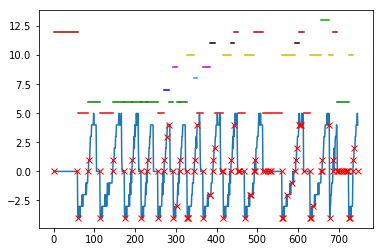

In [32]:
colors = ['r','g','b','c','m','y','k',"#aa0000","#00aa00","#0000aa","#880000","#008800","#000088"]
merged2color = {m:i for i,m in enumerate(sorted(merged))}

for m in merged:
    for t in merged[m]:
        plt.plot(np.array(path[t][1][2:4]),np.array([merged2color[m], merged2color[m]])+5,colors[merged2color[m]])

plt.plot(velocities[:all_times[-1]])
plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
plt.show()

In [21]:
collisions = pickle.load(open('mario_collisions.pkl'))

def button_changes(button_masks):
    last_mask = 0
    mask_times = {}
    for t, b in enumerate(button_masks):
        if b != last_mask:
            b_ = int(b)
            buttons = []
            for ii,c in enumerate(list('RLDUTSBA')):
                if b_ & (1 << (7-ii)):
                    buttons.append(c)
            l_ = int(last_mask)
            last_buttons = []
            for ii,c in enumerate(list('RLDUTSBA')):
                if l_ & (1 << (7-ii)):
                    last_buttons.append(c)
            mask_times[t] = (last_buttons,buttons)
            last_mask = b
    
    return mask_times

button_times = button_changes(track[:,3])
for t in sorted(button_times):
    print t, button_times[t]

0 ([], ['D', 'T'])
15 (['D', 'T'], ['D', 'T', 'A'])
18 (['D', 'T', 'A'], ['D', 'T', 'B'])
19 (['D', 'T', 'B'], ['D', 'T', 'B', 'A'])
21 (['D', 'T', 'B', 'A'], ['D', 'T', 'S'])
23 (['D', 'T', 'S'], ['D', 'T', 'S', 'A'])
24 (['D', 'T', 'S', 'A'], ['D', 'T', 'S', 'B'])
25 (['D', 'T', 'S', 'B'], ['D', 'T', 'S', 'B', 'A'])
26 (['D', 'T', 'S', 'B', 'A'], ['D', 'U'])
27 (['D', 'U'], ['D', 'U', 'A'])
28 (['D', 'U', 'A'], ['D', 'U', 'B'])
29 (['D', 'U', 'B'], ['D', 'U', 'B', 'A'])
30 (['D', 'U', 'B', 'A'], ['D', 'U', 'S'])
31 (['D', 'U', 'S'], ['D', 'U', 'S', 'A'])
32 (['D', 'U', 'S', 'A'], ['D', 'U', 'S', 'B', 'A'])
33 (['D', 'U', 'S', 'B', 'A'], ['D', 'U', 'T'])
34 (['D', 'U', 'T'], ['D', 'U', 'T', 'A'])
35 (['D', 'U', 'T', 'A'], ['D', 'U', 'T', 'B', 'A'])
36 (['D', 'U', 'T', 'B', 'A'], ['D', 'U', 'T', 'S'])
37 (['D', 'U', 'T', 'S'], ['D', 'U', 'T', 'S', 'A'])
38 (['D', 'U', 'T', 'S', 'A'], ['D', 'U', 'T', 'S', 'B'])
39 (['D', 'U', 'T', 'S', 'B'], ['D', 'U', 'T', 'S', 'B', 'A'])
40 (['D', 'U'

In [24]:
start_time = 270
from_x_to_y = {}
to_y = {}
for t in range(1,len(path)):
        if t == 0:
            prev = -1
        else:
            prev = unions[t-1]
            
        start = path[t][1][2]
        
        print t,prev,'->',unions[t], start
        if start in button_times:
            print 'button', button_times[start]
        
        if start+start_time in collisions:
            for c in collisions[start+start_time]:
                print '\t',c
        print ''

1 23 -> 3 59
	((51, 0, 'tile'), 'left')
	((36, 0, 'tile'), 'right')
	((180, 1, 'tile'), 'top')
	((51, 0, 'tile'), 'internal')
	((36, 0, 'tile'), 'left')
	((36, 0, 'tile'), 'bottom')
	((36, 0, 'tile'), 'internal')
	((181, 1, 'tile'), 'top')

2 3 -> 4 85
	((36, 0, 'tile'), 'internal')
	((36, 0, 'tile'), 'right')
	((36, 0, 'tile'), 'bottom')
	((36, 0, 'tile'), 'top')
	((36, 0, 'tile'), 'left')

3 4 -> 3 114
button (['D', 'T', 'A'], ['D', 'T'])
	((180, 1, 'tile'), 'top')
	((52, 0, 'tile'), 'bottom')
	((52, 0, 'tile'), 'internal')
	((38, 0, 'tile'), 'right')
	((38, 0, 'tile'), 'left')
	((52, 0, 'tile'), 'right')
	((38, 0, 'tile'), 'internal')
	((181, 1, 'tile'), 'top')
	((38, 0, 'tile'), 'bottom')

4 3 -> 4 146
	((36, 0, 'tile'), 'internal')
	((36, 0, 'tile'), 'right')
	((36, 0, 'tile'), 'bottom')
	((36, 0, 'tile'), 'top')
	((36, 0, 'tile'), 'left')

5 4 -> 4 173
button (['B'], ['B', 'A'])
	((48, 0, 'tile'), 'bottom')
	((180, 1, 'tile'), 'top')
	((48, 0, 'tile'), 'left')
	((38, 0, 'tile'), 